In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibrationDisplay

import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold, RFE, RFECV
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
)

from sklearn.metrics import (
    accuracy_score, roc_auc_score, brier_score_loss, 
    precision_score, recall_score, f1_score
)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

from tqdm import tqdm
import lime
import lime.lime_tabular
import interpret.glassbox

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display

# Pandas configuration 
pd.set_option('display.max_rows', 100)

# To plot pretty figures 
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

### Create a folder and define the save_fig() function which is used through 
### this notebook to save the figures in hig-res ####

PROJECT_ROOT_DIR = r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data"
CHAPTER_ID = "project_figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
X_train_final = joblib.load('X_train_final_MI.joblib')
y_train_final = joblib.load('y_train_final_MI.joblib')
X_test_final = joblib.load('X_test_final_MI.joblib')
y_test_final = joblib.load('y_test_final_MI.joblib')

In [3]:
print(X_train_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_test_final.shape)

(20409, 20)
(5103, 20)
(20409,)
(5103,)


In [4]:
logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'

)

In [5]:
# Set parameters 
param_distr_lr = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    # remove saga becasue ti was much slower add lbfgs 
    'solver': ['lbfgs'],
    # use a single value to ensure convergance # drop 10000 # 
    'max_iter': [10000] 
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
# Grid Search czyli przeszukiwanie siatki hiperparametrow 
random_search_lr = RandomizedSearchCV(
    # log reg jako bazowy model
    estimator=logreg,
    # testuje rozne kombinacje ze wczesniejszej siatki 
    param_distributions=param_distr_lr,
    n_iter=20,
    # Uzywa 5-krotnej walidacji 
    cv=cv,
    # Wybiera model z najlepszym AUC roc nie accuracy 
    scoring='roc_auc',
    # Uzywa wszytskich dostepnych rdzeni CPU dla przyspieszenia
    n_jobs=1,
    # pokazuje szczegolowy przebieg procesu 
    verbose=3,
    random_state=42
)

In [7]:
# testuje wszytskie parametry z param_grid_lr, wytrenuje model 5 razy
random_search_lr.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.823 total time=   0.0s


C:\Users\aleks\shap-env\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/5] END C=0.1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.839 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.827 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.836 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.822 total time=   0.0s
[CV 1/5] END C=1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.823 total time=   0.0s
[CV 2/5] END C=1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.839 total time=   0.0s
[CV 3/5] END C=1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.827 total time=   0.0s
[CV 4/5] END C=1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.836 total time=   0.0s
[CV 5/5] END C=1, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.822 total time=   0.0s
[CV 1/5] END C=10, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.823 total time=   0.0s
[CV 2/5] END C=10, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.8

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=1000,
                                                random_state=42),
                   n_iter=20, n_jobs=1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'max_iter': [10000], 'penalty': ['l2'],
                                        'solver': ['lbfgs']},
                   random_state=42, scoring='roc_auc', verbose=3)

In [8]:
# Najlepsze parametry 
random_search_lr.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 10000, 'C': 0.1}

In [9]:
best_lr = random_search_lr.best_estimator_

In [10]:
# Najlepszy wynik jaki uzyskano w trakcie CV=5
random_search_lr.best_score_

np.float64(0.8294225173190007)

In [11]:
random_search_lr.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000,
                   random_state=42)

In [12]:
# Log Reg z najlepszy zestawem parametrow 
best_lr = random_search_lr.best_estimator_

In [13]:
#### XGBoost Classifier ####

In [14]:
xgbc = XGBClassifier(
    random_state=42
)

In [15]:
#### grid search for XGBClassifier ####

param_distr_gbc= {
    "n_estimators": [100, 200, 500, 1000], 
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.0, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0], 
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0, 0.1, 0.5, 1]
}

cv = StratifiedKFold(n_splits=5, 
                     shuffle=True, 
                     random_state=42)

In [16]:
### Random search for GBXClassifier ####

random_search_gbc=RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=param_distr_gbc,
    n_iter=20, 
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42) 

In [17]:
# testuje wszytskie parametry z ranodm search gbc, wytrenuje model 5 razy ###
random_search_gbc.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow...
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.7,
                                                             0.8, 1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 500, 1000],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [18]:
# Best params 
random_search_gbc.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.1,
 'reg_alpha': 0,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

In [19]:
# Best score 
random_search_gbc.best_score_

np.float64(0.8332970652454333)

In [20]:
best_gbc=random_search_gbc.best_estimator_
print(best_gbc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)


In [21]:
#### AdaBoost Classifier #### 

In [22]:
#### Ada Boost Classifier ####

# Create the base estimator (Decision Tree)
base_estimator = DecisionTreeClassifier()

# Instantiate AdaBoostClassifier with the base estimator
ada = AdaBoostClassifier(estimator=base_estimator)

#### Set parameters ####

param_distr_ada = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3],  # Control tree depth
    'estimator__min_samples_split': [2, 5],
}

cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)

random_search_ada = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_distr_ada,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=1,
    random_state=42)

In [23]:
random_search_ada.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
                   n_iter=20, n_jobs=1,
                   param_distributions={'estimator__max_depth': [1, 2, 3],
                                        'estimator__min_samples_split': [2, 5],
                                        'learning_rate': [0.01, 0.1, 1.0, 0.5,
                                                          1.0],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [24]:
# Best params 
random_search_ada.best_params_

{'n_estimators': 300,
 'learning_rate': 1.0,
 'estimator__min_samples_split': 2,
 'estimator__max_depth': 1}

In [25]:
# Best score 
random_search_ada.best_score_

np.float64(0.8307095677146721)

In [26]:
best_ada = random_search_ada.best_estimator_
print(best_ada)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=300)


In [27]:
##### Random Forest #####

rf = RandomForestClassifier(random_state=42,
                           class_weight='balanced')


param_distr_rf = {
    'max_features': ['sqrt', 'log2'], # liczba predyktrowo ktore sa consdiered at each split - sqrt of all predictors is the most common. 
    'max_depth' : [4,6,8,10],
    'criterion' :['gini', 'entropy'],
    'n_estimators': [100, 300,500],
    'min_samples_split': [5,10],
    'min_samples_leaf': [4,6,8],
    'bootstrap': [True]
}

cv = StratifiedKFold(n_splits=5, 
                   shuffle=True, 
                   random_state=42)

random_search_rf=RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distr_rf,
    n_iter=20, 
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=1,
    random_state=42
)

In [28]:
random_search_rf.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=20, n_jobs=1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [29]:
# RF best parameters
random_search_rf.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': True}

In [30]:
# Best score RF ###
random_search_rf.best_score_

np.float64(0.8307555472244499)

In [31]:
# RF best model ###
best_rf = random_search_rf.best_estimator_
print(best_rf)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=6, min_samples_split=5,
                       n_estimators=500, random_state=42)


In [32]:
### MLP Classifier ####

In [33]:
#### MLP Classifier #####
## Did not converege with 500, 1000 iterations ####
MLP = MLPClassifier(random_state=42, 
                    max_iter=1000)

param_distr_mlp={
    # 1 layer with 50 neurons, and 1 layer with 100 neurons, 2 layers with 50 neurons 
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['tanh', 'relu'], 
    ## change only to adam after it did not converge 
    'solver':['adam', 'sgd'], 
    'batch_size': ['auto', 32, 64, 128],  
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    # default after 10 if algorithm does not improve then the model stop - prevent overfitting, save time
    'early_stopping': [True],
    'learning_rate': ['constant','adaptive']
}

cv = StratifiedKFold(n_splits=3, 
                     shuffle=True, 
                     random_state=42)
### MLP nie zdazyl nauczyc sie w 200 epokach (siec nie zminimalizowala bledu do zadowalajacego poziomu
### dlatego ustawimay max_iter 500 bo dostalismy error. 

random_search_MLP = RandomizedSearchCV(
    estimator=MLP,
    param_distributions=param_distr_mlp,
    # mniejsza liczba kombinacji 
    n_iter=20, 
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=1,
    random_state=42
)

In [34]:
random_search_MLP.fit(X_train_final, y_train_final)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MLPClassifier(max_iter=1000, random_state=42),
                   n_iter=20, n_jobs=1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01, 0.05,
                                                  0.1],
                                        'batch_size': ['auto', 32, 64, 128],
                                        'early_stopping': [True],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='roc_auc', verbose=1)

In [35]:
# MLP best parameters # 
random_search_MLP.best_params_

{'solver': 'adam',
 'learning_rate': 'constant',
 'hidden_layer_sizes': (100,),
 'early_stopping': True,
 'batch_size': 64,
 'alpha': 0.05,
 'activation': 'tanh'}

In [36]:
# MLP best score #
random_search_MLP.best_score_

np.float64(0.8288262935443343)

In [37]:
# MLP - best model # 
best_mlp = random_search_MLP.best_estimator_

Cross validation: Logistic Regression


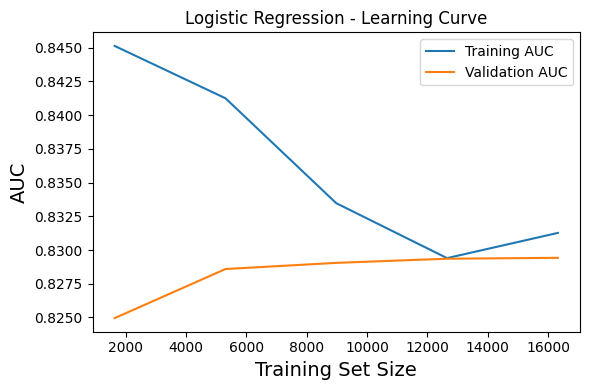

Cross validation: Random Forest


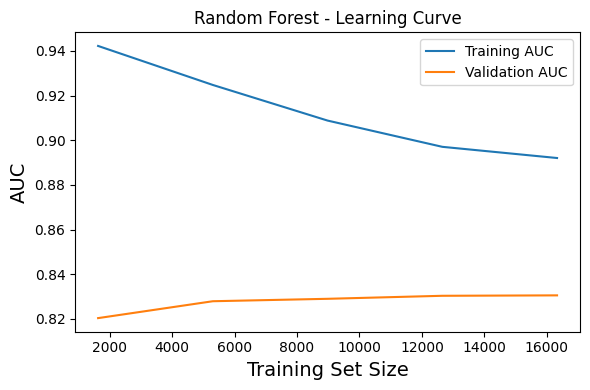

Cross validation: AdaBoost


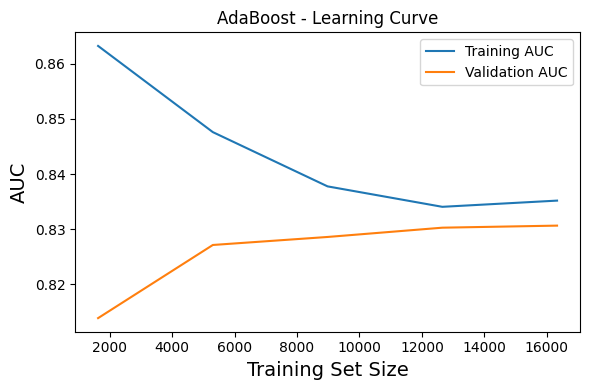

Cross validation: MLP


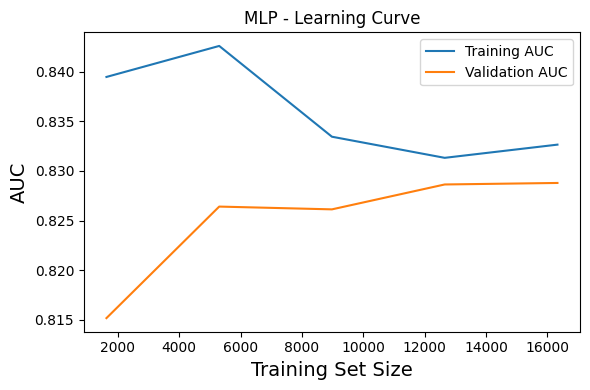

Cross validation: XGBoost


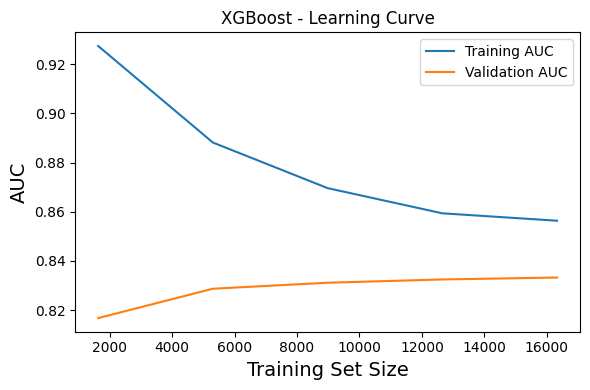

In [38]:
# Best estimators from RandomizedSearchCV
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "AdaBoost": best_ada,
    "MLP": best_mlp,
    "XGBoost": best_gbc
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
learning_curve_results = {}

# Cross-validation with proper SMOTE application
for name, model in models.items():
    print(f"Cross validation: {name}")
    aucs, f1s, precisions, recalls, briers, accuracies = [], [], [], [], [], []
    
    for train_idx, val_idx in cv.split(X_train_final, y_train_final):
        # Split original data
        X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]
        
        # Apply SMOTE only to training fold
        smote = SMOTE(random_state=42)
        X_tr_resampled, y_tr_resampled = smote.fit_resample(X_tr, y_tr)
        
        # Train on resampled data, validate on original data
        model.fit(X_tr_resampled, y_tr_resampled)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        
        aucs.append(roc_auc_score(y_val, y_proba))
        f1s.append(f1_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        accuracies.append(accuracy_score(y_val, y_pred))
        briers.append(brier_score_loss(y_val, y_proba))
    
    results.append({
        "Model": name,
        "AUC Mean": np.mean(aucs),
        "F1 Mean": np.mean(f1s),
        "Precision Mean": np.mean(precisions),
        "Recall Mean": np.mean(recalls),
        "Accuracy Mean": np.mean(accuracies),
        "Brier Score Mean": np.mean(briers),
    })
    
    # Learning curve (without SMOTE for simplicity and consistency)
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_final, y_train_final,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5),
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        learning_curve_results[name] = {
            'train_sizes': train_sizes,
            'train_auc': train_scores_mean,
            'val_auc': val_scores_mean
        }
        
        plt.figure(figsize=(6, 4))
        plt.plot(train_sizes, train_scores_mean, label="Training AUC")
        plt.plot(train_sizes, val_scores_mean, label="Validation AUC")
        plt.title(f"{name} - Learning Curve")
        plt.xlabel("Training Set Size")
        plt.ylabel("AUC")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not generate learning curve for {name}: {e}")

In [39]:
# Final performance summary
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data\'model_cv_results_optimisation.csv", index=False)

                 Model  AUC Mean   F1 Mean  Precision Mean  Recall Mean  \
0  Logistic Regression  0.813420  0.541801        0.445598     0.691245   
1        Random Forest  0.825674  0.553252        0.542586     0.564931   
2             AdaBoost  0.827141  0.538496        0.597175     0.490481   
3                  MLP  0.812131  0.538357        0.430760     0.721702   
4              XGBoost  0.829838  0.534949        0.630926     0.464553   

   Accuracy Mean  Brier Score Mean  
0       0.759125          0.166020  
1       0.812141          0.134347  
2       0.826841          0.228170  
3       0.744572          0.171253  
4       0.833652          0.120909  


In [40]:
df_results.to_csv(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data\'model_cv_results_optimisation.csv", index=False)

In [41]:

results_test = []

for name, model in models.items():
    print(f"Testing model: {name}")
    
    # Predykcja klas i prawdopodobieństw
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]

    # Oblicz metryki
    auc = roc_auc_score(y_test_final, y_proba)
    f1 = f1_score(y_test_final, y_pred)
    precision = precision_score(y_test_final, y_pred)
    recall = recall_score(y_test_final, y_pred)
    brier = brier_score_loss(y_test_final, y_proba)
    accuracy = accuracy_score(y_test_final, y_pred)

    # Zapisz wyniki
    results_test.append({
        "Model": name,
        "AUC": auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Brier Score": brier,
        "Accuracy": accuracy
    })

    # (opcjonalnie) pełny raport
    print("\nClassification Report:\n", classification_report(y_test_final, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test_final, y_pred))


Testing model: Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      4052
           1       0.43      0.68      0.53      1051

    accuracy                           0.75      5103
   macro avg       0.67      0.72      0.68      5103
weighted avg       0.81      0.75      0.77      5103

Confusion Matrix:
 [[3116  936]
 [ 337  714]]
Testing model: Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4052
           1       0.54      0.55      0.54      1051

    accuracy                           0.81      5103
   macro avg       0.71      0.71      0.71      5103
weighted avg       0.81      0.81      0.81      5103

Confusion Matrix:
 [[3554  498]
 [ 472  579]]
Testing model: AdaBoost

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91   

In [42]:
df_test_results = pd.DataFrame(results_test)
df_test_results = df_test_results.round(4)
print(df_test_results.sort_values(by="AUC", ascending=False))
df_test_results.to_csv(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data\'model_test_results.csv", index=False)

                 Model     AUC      F1  Precision  Recall  Brier Score  \
4              XGBoost  0.8134  0.5082     0.6005  0.4405       0.1260   
1        Random Forest  0.8102  0.5442     0.5376  0.5509       0.1390   
2             AdaBoost  0.8086  0.5086     0.5637  0.4634       0.2288   
3                  MLP  0.7930  0.5065     0.3883  0.7279       0.1916   
0  Logistic Regression  0.7922  0.5287     0.4327  0.6794       0.1728   

   Accuracy  
4    0.8244  
1    0.8099  
2    0.8156  
3    0.7078  
0    0.7505  


Saving figure Evalutation metrics on Test Set


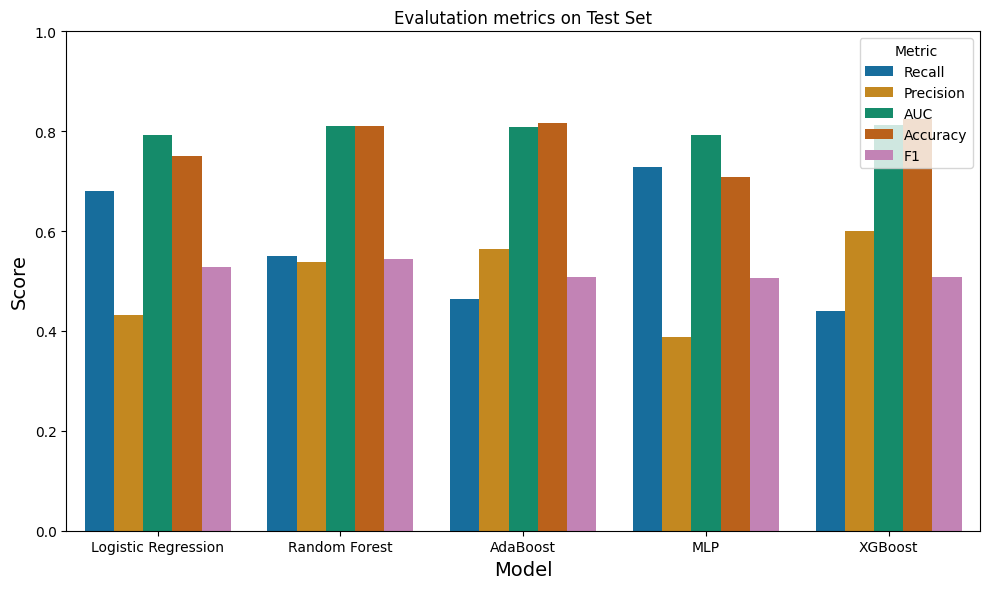

In [43]:
# Zakładamy, że df_test_results ma kolumny: Model, Recall, Precision
df_melted = df_test_results.melt(
    id_vars="Model", 
    value_vars=["Recall", "Precision", "AUC", "Accuracy", "F1"],
    var_name="Metric",
    value_name="Score"
)

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_melted, 
    x="Model", 
    y="Score", 
    hue="Metric", 
    palette="colorblind"
)

plt.title("Evalutation metrics on Test Set")
plt.ylim(0.0, 1.0)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
save_fig("Evalutation metrics on Test Set")
plt.show()

In [44]:
## https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html ##
#### Bootstrapping test set for best_lr ####
y_proba_lr=best_lr.predict_proba(X_test_final)[:,1]
## Tworzy losowy generator liczb ## 
rng = np.random.RandomState(seed=42)
## 1000 powtorzen bootstrapping ##
## czyli tysiac razy losujesz probke ###
n_iterations = 1000

# idx indeksy pozycyjne twojego zbioru y_test ###
idx = np.arange(len(y_test_final))

auc_scores = []

for i in range(n_iterations):
    sample_idx = rng.choice(idx, size=len(y_test_final), replace=True)
    y_true_sample = y_test_final.iloc[sample_idx]
    y_proba_sample = y_proba_lr[sample_idx]
    auc_scores.append(roc_auc_score(y_true_sample, y_proba_sample))

ci_lower, ci_upper = np.percentile(auc_scores, [2.5, 97.5])
print("AUC Logistic Regression 95% CI:", ci_lower, ci_upper)

AUC Logistic Regression 95% CI: 0.7760954721835758 0.807103696358751


In [45]:
y_proba_gbc=best_gbc.predict_proba(X_test_final)[:,1]

## https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html ##
#### Bootstrapping test set for best_lr ####
### This method avoids retraining the model and is 

## Tworzy losowy generator liczb ## 
rng = np.random.RandomState(seed=42)
## 1000 powtorzen bootstrapping ##
## czyli tysiac razy losujesz probke ###
n_iterations = 1000

# idx indeksy pozycyjne twojego zbioru y_test ###
idx = np.arange(len(y_test_final))

# Empty list #
auc_scores_gbc = []
# For loop ktora sie wykona 1000 ##
for i in range(n_iterations):
    # rng.choice losuje z tych indeksow z zastepowaniem czyli niekotre indeksy,
    # moga sie powtarzac, inne nie wystapia w ogole ### 
    ## taka smaoe dlusgosc jak y_test (tyle samoe obesvations ale 
    # inny zawartosc i kolejnosc jest inna 
    # Ktore obserwacje testowe wexmiemy do analizy tym razem? #
    sample_idx = rng.choice(idx, size=len(y_test_final), replace=True)
    # Jakie sa prawdziwe etykiety (0,1) tych obserwacji? 
    # Czyli co bylo w danych na prawde dlatego true sample ###
    y_true_sample = y_test_final.iloc[sample_idx]
    # Jakie prawdopodobienstow przewidzial model do tych obserwacji? 
    # Co model przewidzial? czylie 0.88 ze 1 itd. 
    y_proba_sample = y_proba_gbc[sample_idx]
    # Jak dobrze poradzil sobie model na tej probie? ###
    auc_scores_gbc.append(roc_auc_score(y_true_sample, y_proba_sample))

ci_lower_gbc, ci_upper_gbc = np.percentile(auc_scores_gbc, [2.5, 97.5])
auc_mean_gbc = np.mean(auc_scores_gbc)
print("AUC XGBClassifier 95% CI:", ci_lower_gbc, ci_upper_gbc)

AUC XGBClassifier 95% CI: 0.7992236769104065 0.8274318141929161


In [46]:
y_proba_ada = best_ada.predict_proba(X_test_final)[:,1]

##### AUC CI for Ada Boost ####
## https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html ##
#### Bootstrapping test set for best_lr ####
### This method avoids retraining the model and is 

## Tworzy losowy generator liczb ## 
rng = np.random.RandomState(seed=42)
## 1000 powtorzen bootstrapping ##
## czyli tysiac razy losujesz probke ###
n_iterations = 1000

# idx indeksy pozycyjne twojego zbioru y_test ###
idx = np.arange(len(y_test_final))

# Empty list #
auc_scores_ada = []
# For loop ktora sie wykona 1000 ##
for i in range(n_iterations):
    # rng.choice losuje z tych indeksow z zastepowaniem czyli niekotre indeksy,
    # moga sie powtarzac, inne nie wystapia w ogole ### 
    ## taka smaoe dlusgosc jak y_test (tyle samoe obesvations ale 
    # inny zawartosc i kolejnosc jest inna 
    # Ktore obserwacje testowe wexmiemy do analizy tym razem? #
    sample_idx = rng.choice(idx, size=len(y_test_final), replace=True)
    # Jakie sa prawdziwe etykiety (0,1) tych obserwacji? 
    # Czyli co bylo w danych na prawde dlatego true sample ###
    y_true_sample = y_test_final.iloc[sample_idx]
    # Jakie prawdopodobienstow przewidzial model do tych obserwacji? 
    # Co model przewidzial? czylie 0.88 ze 1 itd. 
    y_proba_sample = y_proba_gbc[sample_idx]
    # Jak dobrze poradzil sobie model na tej probie? ###
    auc_scores_ada.append(roc_auc_score(y_true_sample, y_proba_sample))

ci_lower_ada, ci_upper_ada = np.percentile(auc_scores_ada, [2.5, 97.5])
auc_mean_ada = np.mean(auc_scores_ada)
print("AUC AdaBoost 95% CI:", ci_lower_ada, ci_upper_ada)

AUC AdaBoost 95% CI: 0.7992236769104065 0.8274318141929161


In [47]:
y_proba_rf = best_rf.predict_proba(X_test_final)[:, 1]

## https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html ##
#### Bootstrapping test set for best_lr ####
### This method avoids retraining the model and is 

## Tworzy losowy generator liczb ## 
rng = np.random.RandomState(seed=42)
## 1000 powtorzen bootstrapping ##
## czyli tysiac razy losujesz probke ###
n_iterations = 1000

# idx indeksy pozycyjne twojego zbioru y_test ###
idx = np.arange(len(y_test_final))

# Empty list #
auc_scores_rf = []
# For loop ktora sie wykona 1000 ##
for i in range(n_iterations):
    # rng.choice losuje z tych indeksow z zastepowaniem czyli niekotre indeksy,
    # moga sie powtarzac, inne nie wystapia w ogole ### 
    ## taka smaoe dlusgosc jak y_test (tyle samoe obesvations ale 
    # inny zawartosc i kolejnosc jest inna 
    # Ktore obserwacje testowe wexmiemy do analizy tym razem? #
    sample_idx = rng.choice(idx, size=len(y_test_final), replace=True)
    # Jakie sa prawdziwe etykiety (0,1) tych obserwacji? 
    # Czyli co bylo w danych na prawde dlatego true sample ###
    y_true_sample = y_test_final.iloc[sample_idx]
    # Jakie prawdopodobienstow przewidzial model do tych obserwacji? 
    # Co model przewidzial? czylie 0.88 ze 1 itd. 
    y_proba_sample = y_proba_rf[sample_idx]
    # Jak dobrze poradzil sobie model na tej probie? ###
    auc_scores_rf.append(roc_auc_score(y_true_sample, y_proba_sample))

ci_lower_rf, ci_upper_rf = np.percentile(auc_scores_rf, [2.5, 97.5])
auc_mean_rf = np.mean(auc_scores_rf)
print("AUC Random Forest 95% CI:", ci_lower_rf, ci_upper_rf)

AUC Random Forest 95% CI: 0.7954827912164367 0.8241422396041069


In [48]:
y_proba_mlp = best_mlp.predict_proba(X_test_final)[:, 1] 

## https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html ##
#### Bootstrapping test set for best_lr ####
### This method avoids retraining the model and is 

## Tworzy losowy generator liczb ## 
rng = np.random.RandomState(seed=42)
## 1000 powtorzen bootstrapping ##
## czyli tysiac razy losujesz probke ###
n_iterations = 1000

# idx indeksy pozycyjne twojego zbioru y_test ###
idx = np.arange(len(y_test_final))

# Empty list #
auc_scores_mlp = []
# For loop ktora sie wykona 1000 ##
for i in range(n_iterations):
    # rng.choice losuje z tych indeksow z zastepowaniem czyli niekotre indeksy,
    # moga sie powtarzac, inne nie wystapia w ogole ### 
    ## taka smaoe dlusgosc jak y_test (tyle samoe obesvations ale 
    # inny zawartosc i kolejnosc jest inna 
    # Ktore obserwacje testowe wexmiemy do analizy tym razem? #
    sample_idx = rng.choice(idx, size=len(y_test_final), replace=True)
    # Jakie sa prawdziwe etykiety (0,1) tych obserwacji? 
    # Czyli co bylo w danych na prawde dlatego true sample ###
    y_true_sample = y_test_final.iloc[sample_idx]
    # Jakie prawdopodobienstow przewidzial model do tych obserwacji? 
    # Co model przewidzial? czylie 0.88 ze 1 itd. 
    y_proba_sample = y_proba_mlp[sample_idx]
    # Jak dobrze poradzil sobie model na tej probie? ###
    auc_scores_mlp.append(roc_auc_score(y_true_sample, y_proba_sample))

ci_lower_mlp, ci_upper_mlp = np.percentile(auc_scores_mlp, [2.5, 97.5])
auc_mean_mlp = np.mean(auc_scores_mlp)
print("AUC MLP Classifier 95% CI:", ci_lower_mlp, ci_upper_mlp)

AUC MLP Classifier 95% CI: 0.7778670033386982 0.8077610195743636


Saving figure Confusion Matrix - Logistic Regression (Test Set)


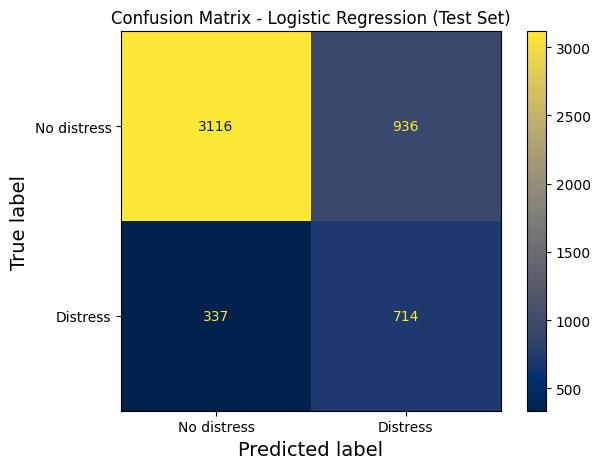

In [49]:
# Predykcja
y_pred = best_lr.predict(X_test_final)

# Macierz błędów
cm = confusion_matrix(y_test_final, y_pred)

# Wyświetlenie z paletą cividis
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No distress", "Distress"])
disp.plot(cmap='cividis')  

plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.grid(False)
save_fig("Confusion Matrix - Logistic Regression (Test Set)")
plt.show()

Saving figure Confusion Matrix - Random Forest (Test Set)


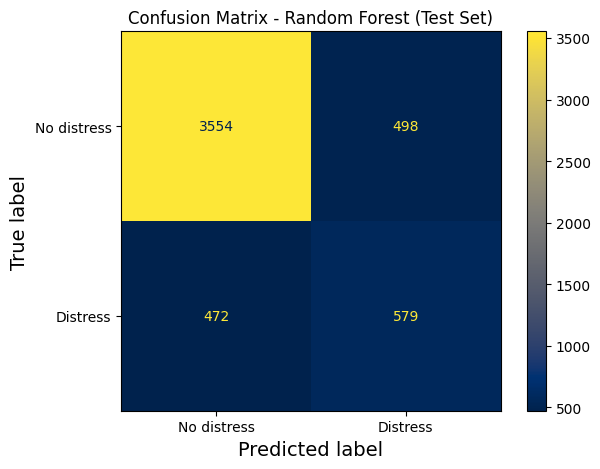

In [50]:
# Predykcja
y_pred = best_rf.predict(X_test_final)

# Macierz błędów
cm = confusion_matrix(y_test_final, y_pred)

# Wyświetlenie z paletą cividis
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No distress", "Distress"])
disp.plot(cmap='cividis')  

plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.grid(False)
save_fig("Confusion Matrix - Random Forest (Test Set)")
plt.show()

Saving figure Confusion Matrix - AdaBoost (Test Set)


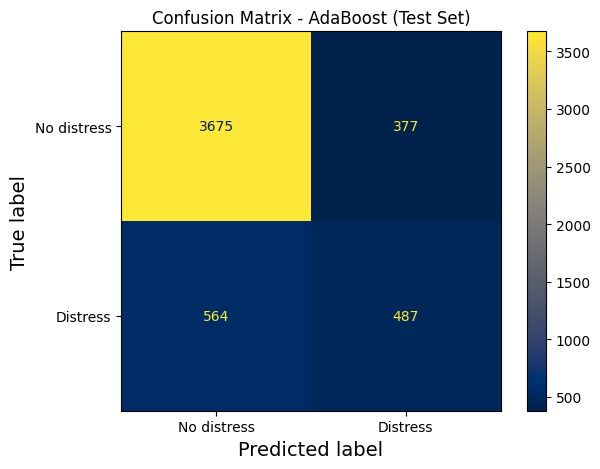

In [51]:
# Prediction
y_pred = best_ada.predict(X_test_final)

# Confusion matrix 
cm = confusion_matrix(y_test_final, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No distress", "Distress"])
disp.plot(cmap='cividis')  

plt.title("Confusion Matrix - AdaBoost (Test Set)")
plt.grid(False)
save_fig("Confusion Matrix - AdaBoost (Test Set)")
plt.show()

Saving figure Confusion Matrix - MLP (Test Set)


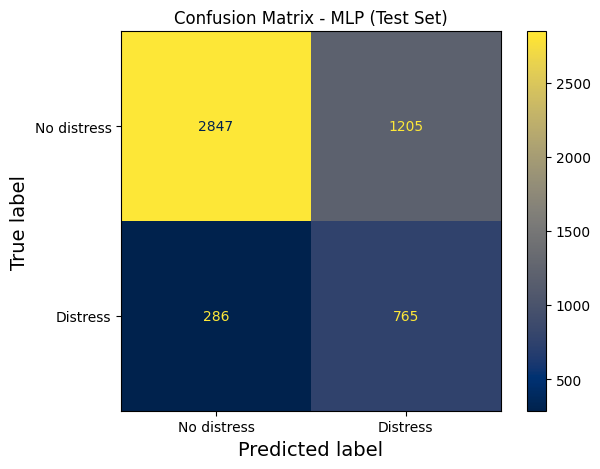

In [52]:
# Predykcja
y_pred = best_mlp.predict(X_test_final)

# Macierz błędów
cm = confusion_matrix(y_test_final, y_pred)

# Wyświetlenie z paletą cividis
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No distress", "Distress"])
disp.plot(cmap='cividis')  

plt.title("Confusion Matrix - MLP (Test Set)")
plt.grid(False)
save_fig("Confusion Matrix - MLP (Test Set)")
plt.show()


Saving figure Confusion Matrix - XGBoost (Test Set)


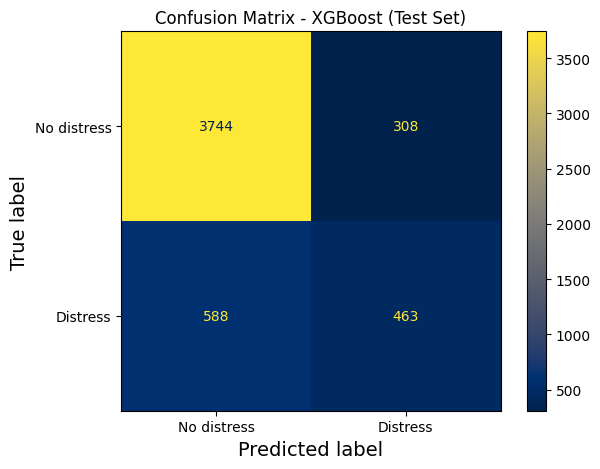

In [53]:
# Predykcja
y_pred = best_gbc.predict(X_test_final)

# Macierz błędów
cm = confusion_matrix(y_test_final, y_pred)

# Wyświetlenie z paletą cividis
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No distress", "Distress"])
disp.plot(cmap='cividis')  

plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.grid(False)
save_fig("Confusion Matrix - XGBoost (Test Set)")
plt.show()

In [54]:
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/ # 
yhat = best_rf.predict_proba(X_test_final)[:, 1]

In [55]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get predicted probabilities for positive class
yhat = model.predict_proba(X_test_final)[:, 1]

# PR curve
precision, recall, thresholds = precision_recall_curve(y_test_final, yhat)

# F1 for each threshold
fscore = (2 * precision * recall) / (precision + recall)

# Find best threshold
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
best_f1 = fscore[ix]
best_precision = precision[ix]
best_recall = recall[ix]

print(f"Best Threshold={best_threshold:.3f}, F1={best_f1:.3f}, Precision={best_precision:.3f}, Recall={best_recall:.3f}")

Best Threshold=0.348, F1=0.553, Precision=0.497, Recall=0.623


Saving figure PR Curve (Best Threshold)


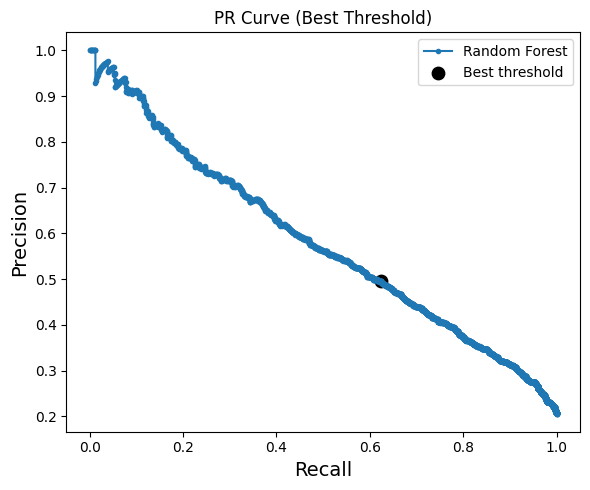

In [56]:
plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold', s=80)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR Curve (Best Threshold)')
save_fig('PR Curve (Best Threshold)')
plt.show()

In [57]:
# Adjusted threshold
best_threshold = 0.348


y_proba = best_rf.predict_proba(X_test_final)[:, 1]


y_pred_opt = (y_proba >= best_threshold).astype(int)

# Metrics for random forest with optimal threshold 
auc = roc_auc_score(y_test_final, y_proba)
f1 = f1_score(y_test_final, y_pred_opt)
prec = precision_score(y_test_final, y_pred_opt)
rec = recall_score(y_test_final, y_pred_opt)
acc = accuracy_score(y_test_final, y_pred_opt)
brier = brier_score_loss(y_test_final, y_proba)

# DataFrame z wynikami
metrics_rf_opt = pd.DataFrame([{
    'Model': 'Random Forest',
    'AUC': auc,
    'F1': f1,
    'Precision': prec,
    'Recall': rec,
    'Accuracy': acc,
    'Brier Score': brier,
    'Best Threshold': best_threshold
}])

Saving figure Confusion Matrix - Random Forest (Threshold = 0.348)


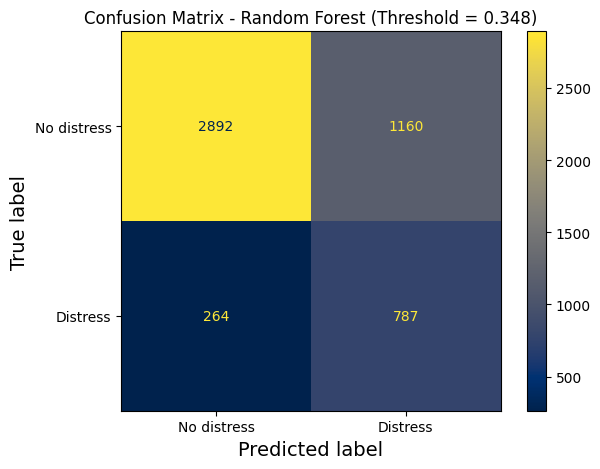

In [58]:
# Macierz pomyłek
cm = confusion_matrix(y_test_final, y_pred_opt)

# Wyświetlenie
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No distress", "Distress"])
disp.plot(cmap='cividis')
plt.title("Confusion Matrix - Random Forest (Threshold = 0.348)")
plt.grid(False)
save_fig("Confusion Matrix - Random Forest (Threshold = 0.348)")
plt.show()

In [59]:
print(metrics_rf_opt)

           Model       AUC        F1  Precision    Recall  Accuracy  \
0  Random Forest  0.810218  0.525017   0.404212  0.748811  0.720948   

   Brier Score  Best Threshold  
0     0.138987           0.348  


Saving figure Top 20 Most Important Features - Random Forest


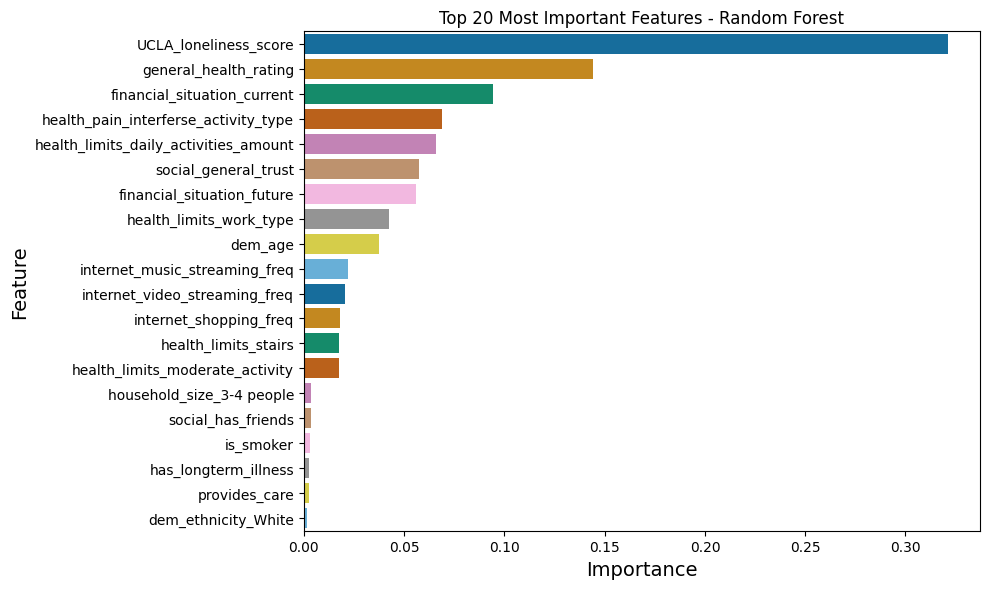

In [60]:
importances = best_rf.feature_importances_
feature_names = X_train_final.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


top_n = 20  
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp_df.head(top_n),
    x='Importance',
    y='Feature',
    palette='colorblind'
)
plt.title("Top 20 Most Important Features - Random Forest")
plt.tight_layout()
plt.grid(False)

save_fig("Top 20 Most Important Features - Random Forest")
plt.show()

In [62]:
import shap as shap 
explainer_rf = shap.TreeExplainer(best_rf)  # No background needed
shap_values_rf = explainer_rf(X_test_final)

C:\Users\aleks\shap-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
print(type(shap_values_rf))
print(shap_values_rf.shape)
print(X_test_final.shape)

<class 'shap._explanation.Explanation'>
(5103, 20, 2)
(5103, 20)


In [64]:
shap_values_class1 = shap.Explanation(
    values=shap_values_rf.values[:, :, 1],  # class 1 = distressed 
    base_values=shap_values_rf.base_values[:, 1],
    data=shap_values_rf.data,
    feature_names=shap_values_rf.feature_names
)

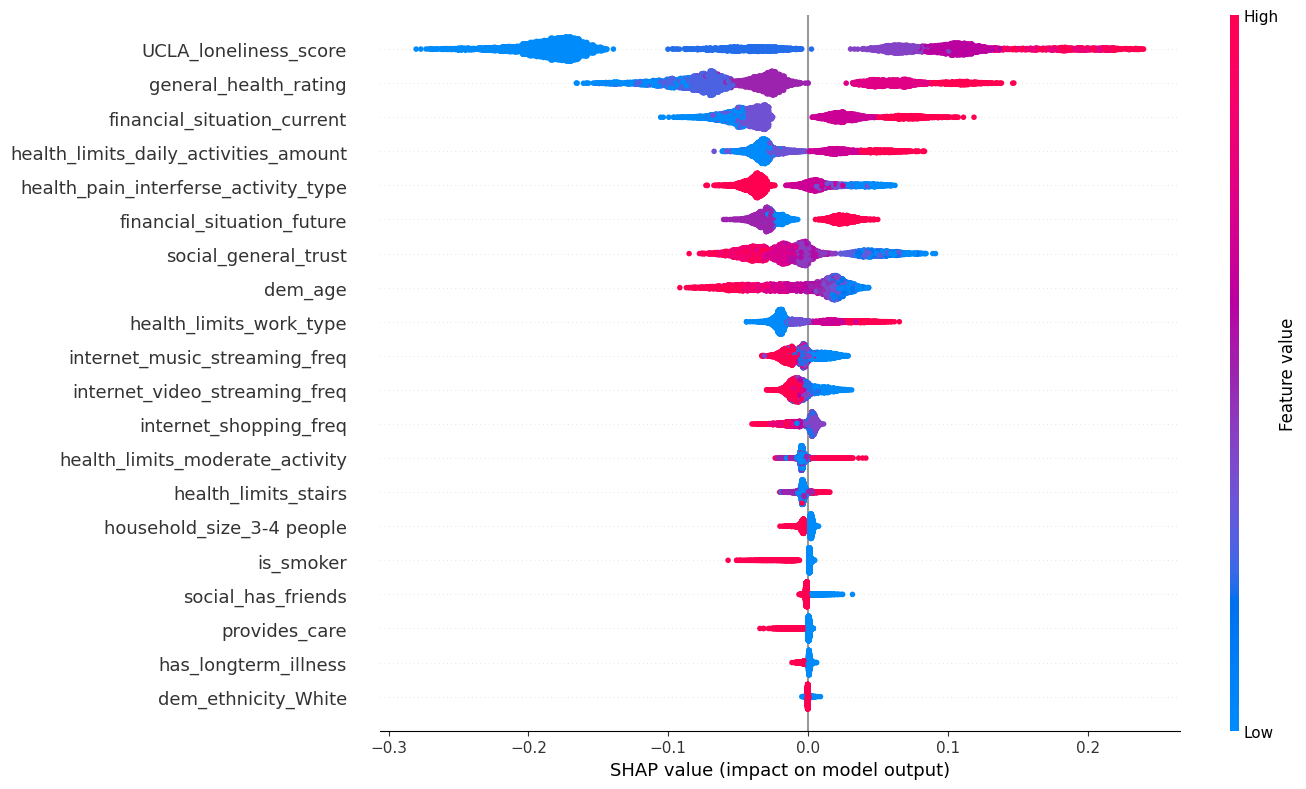

In [65]:
shap.summary_plot(
    shap_values_class1,
    show=False,
    plot_type="dot",
    max_display=20,
    plot_size=(14, 8)   
)
plt.savefig("shap_beeswarm_wide.png", dpi=300, bbox_inches="tight")
plt.show()

In [66]:
# After slicing for class 1
vals_class1 = shap_values_rf.values[:, :, 1]
base_class1 = shap_values_rf.base_values[:, 1]
print("Class 1 SHAP shape:", vals_class1.shape)
print("Class 1 base shape:", base_class1.shape)

Class 1 SHAP shape: (5103, 20)
Class 1 base shape: (5103,)


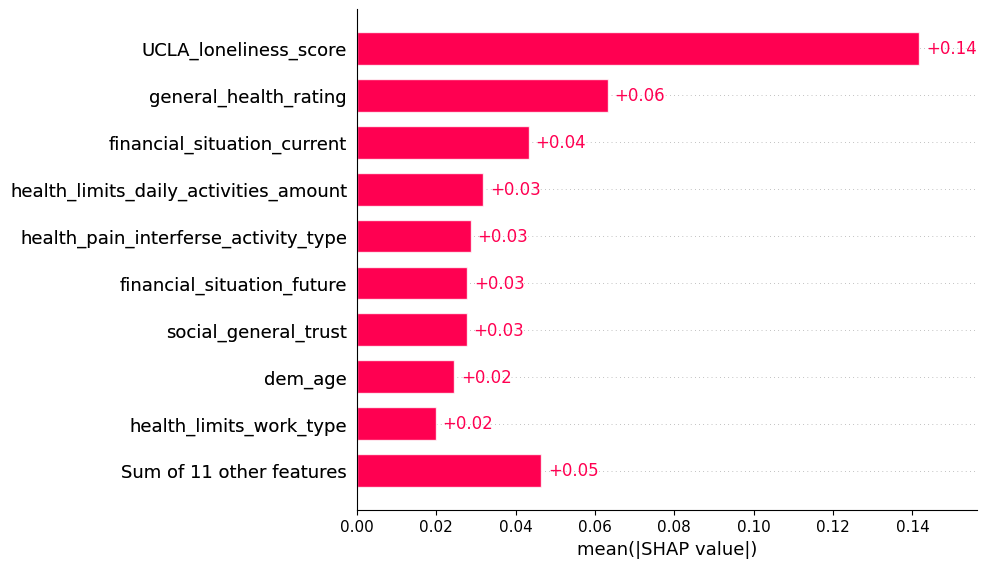

In [67]:
shap.plots.bar(shap_values_class1, show=False)
plt.savefig('Mean_SHAP_values.png', bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

In [68]:
print(shap_values_class1.shape)
print(type(shap_values_class1))
print(shap_values_class1.feature_names)

(5103, 20)
<class 'shap._explanation.Explanation'>
['dem_age', 'provides_care', 'social_has_friends', 'has_longterm_illness', 'general_health_rating', 'health_limits_moderate_activity', 'health_limits_stairs', 'health_limits_daily_activities_amount', 'health_limits_work_type', 'health_pain_interferse_activity_type', 'social_general_trust', 'internet_shopping_freq', 'internet_video_streaming_freq', 'internet_music_streaming_freq', 'is_smoker', 'financial_situation_current', 'financial_situation_future', 'UCLA_loneliness_score', 'dem_ethnicity_White', 'household_size_3-4 people']


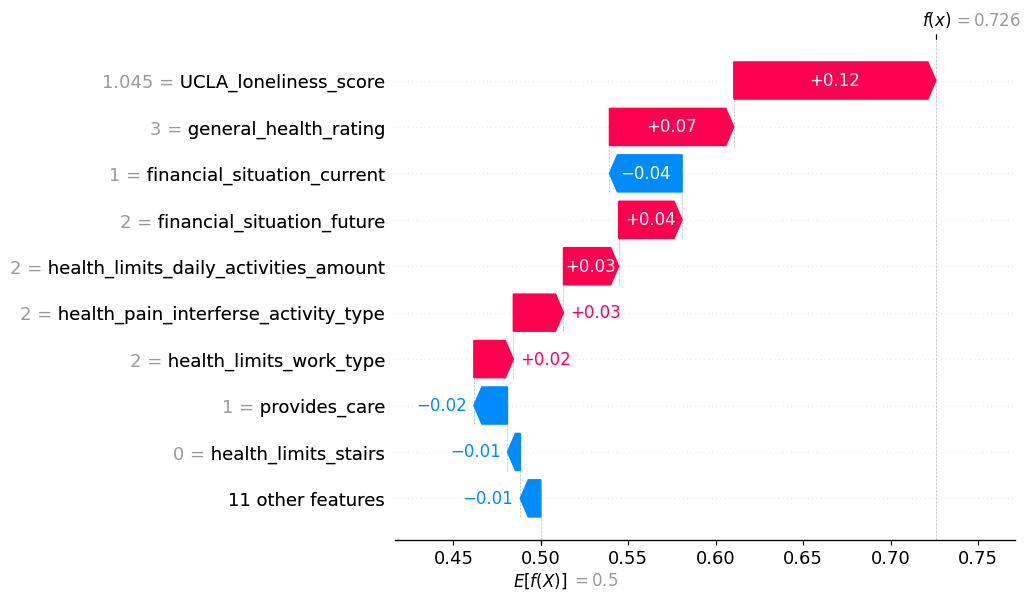

In [69]:
shap.waterfall_plot(shap_values_class1[37], show=False)
plt.savefig("shap_waterfall.png", dpi=300, bbox_inches="tight")
plt.show()

In [70]:
# Create an explainer 
explainer = shap.TreeExplainer(best_rf) 
shap_values = explainer(X_test_final)

# Force plot dla pierwszej obserwacji (indeks 0)
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],    # wartość bazowa dla klasy 1
    shap_values.values[25,:,1],     # wartości SHAP dla tej obserwacji
    X_test_final.iloc[25,:]         
)


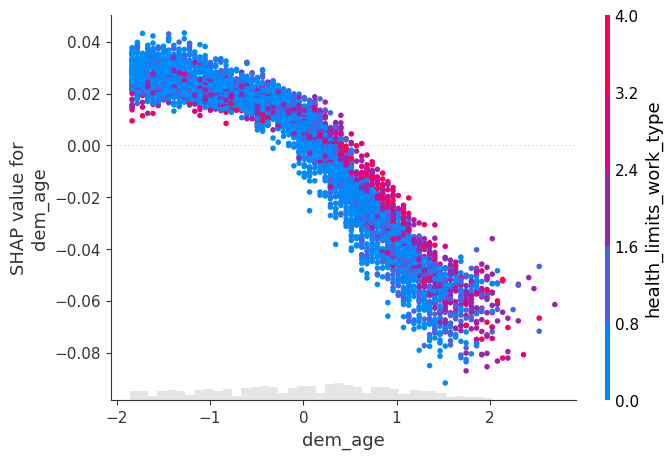

In [71]:
shap.plots.scatter(shap_values_class1[:, "dem_age"], color=shap_values_class1)

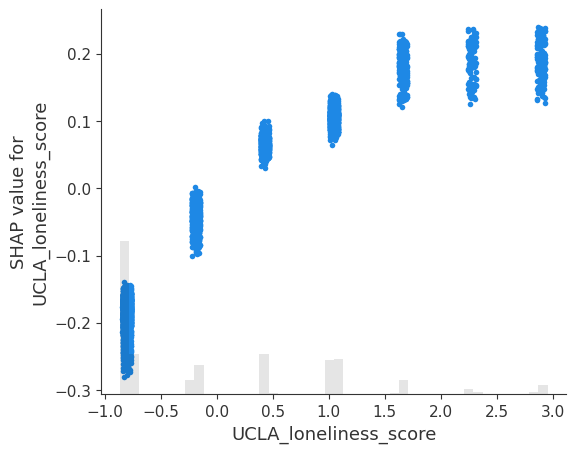

In [72]:
shap.plots.scatter(shap_values_class1[:, "UCLA_loneliness_score"])

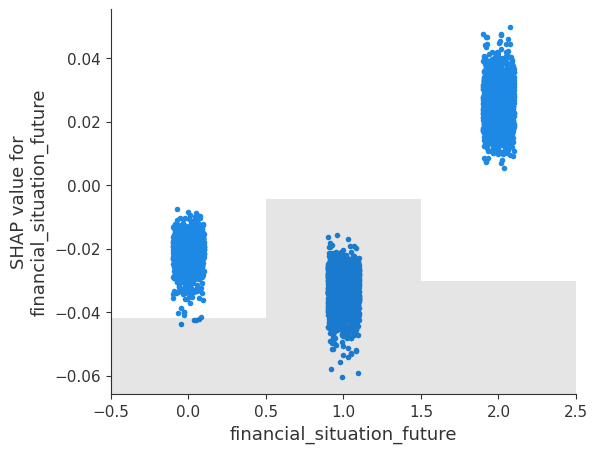

In [73]:
shap.plots.scatter(shap_values_class1[:, "financial_situation_future"])

In [74]:
X_train_final = pd.DataFrame(X_train_final, columns=feature_names)

In [75]:
X_test_final = pd.DataFrame(X_test_final, columns=feature_names)

In [76]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final.values,  # or np.array(X_train_final)
    feature_names=X_train_final.columns.tolist(),
    class_names=["No Distress", "Distress"],
    mode="classification"
)

In [77]:
i = 10 
exp = lime_explainer.explain_instance(
    data_row=X_test_final.iloc[i],
    predict_fn=best_rf.predict_proba,
    num_features=10
)

C:\Users\aleks\shap-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [78]:
print("Model features:", best_rf.feature_names_in_)
print("Current features:", feature_names)
print("Match:", list(best_rf.feature_names_in_) == list(feature_names))

Model features: ['dem_age' 'provides_care' 'social_has_friends' 'has_longterm_illness'
 'general_health_rating' 'health_limits_moderate_activity'
 'health_limits_stairs' 'health_limits_daily_activities_amount'
 'health_limits_work_type' 'health_pain_interferse_activity_type'
 'social_general_trust' 'internet_shopping_freq'
 'internet_video_streaming_freq' 'internet_music_streaming_freq'
 'is_smoker' 'financial_situation_current' 'financial_situation_future'
 'UCLA_loneliness_score' 'dem_ethnicity_White' 'household_size_3-4 people']
Current features: Index(['dem_age', 'provides_care', 'social_has_friends',
       'has_longterm_illness', 'general_health_rating',
       'health_limits_moderate_activity', 'health_limits_stairs',
       'health_limits_daily_activities_amount', 'health_limits_work_type',
       'health_pain_interferse_activity_type', 'social_general_trust',
       'internet_shopping_freq', 'internet_video_streaming_freq',
       'internet_music_streaming_freq', 'is_smoker',


Saving figure Case 01


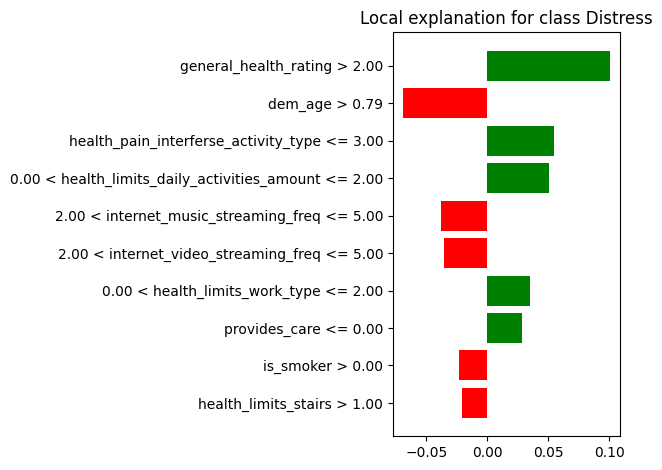

In [79]:
fig = exp.as_pyplot_figure()
fig.patch.set_facecolor('white')
save_fig("Case 01")
plt.show()

Saving figure Case 01


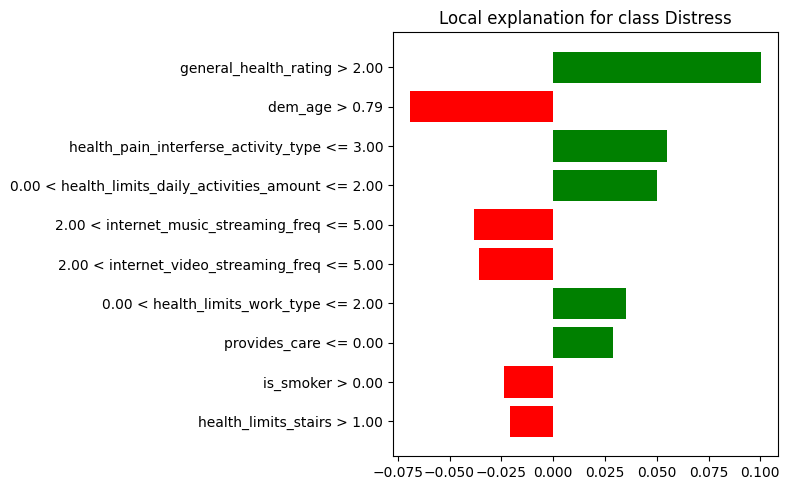

In [80]:
fig = exp.as_pyplot_figure(label=1)   # 1 = klasa "Distress" 
fig.set_size_inches(8, 5)
plt.tight_layout()
save_fig("Case 01")
plt.show()

In [81]:
i = 37
exp = lime_explainer.explain_instance(
    data_row=X_test_final.iloc[i],
    predict_fn=best_rf.predict_proba,
    num_features=10
)

C:\Users\aleks\shap-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving figure Case 01


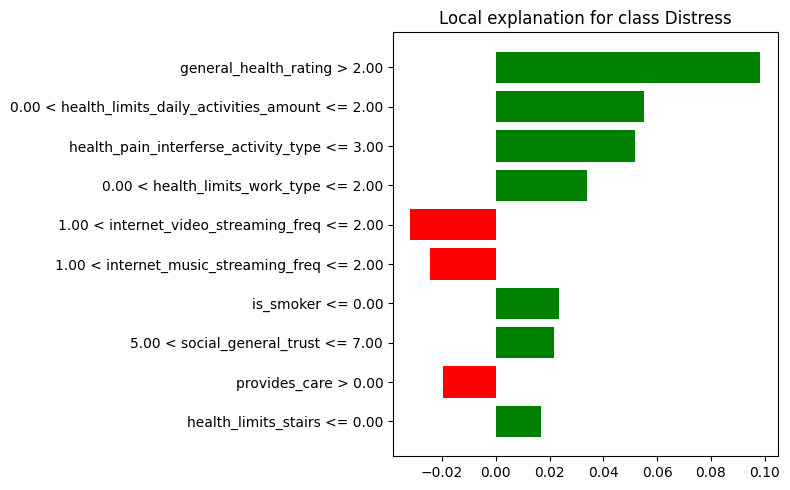

In [82]:
fig = exp.as_pyplot_figure(label=1)   # 1 = klasa "Distress" 
fig.set_size_inches(8, 5)
plt.tight_layout()
save_fig("Case 01")
plt.show()